In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with = engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Measurement.metadata.tables['measurement']

Station = Base.classes.station
Station.metadata.tables['station']

Table('station', MetaData(), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None)

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [38]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement).order_by(Measurement.date.desc()).limit(1).scalar().date
recent_date


'2017-08-23'

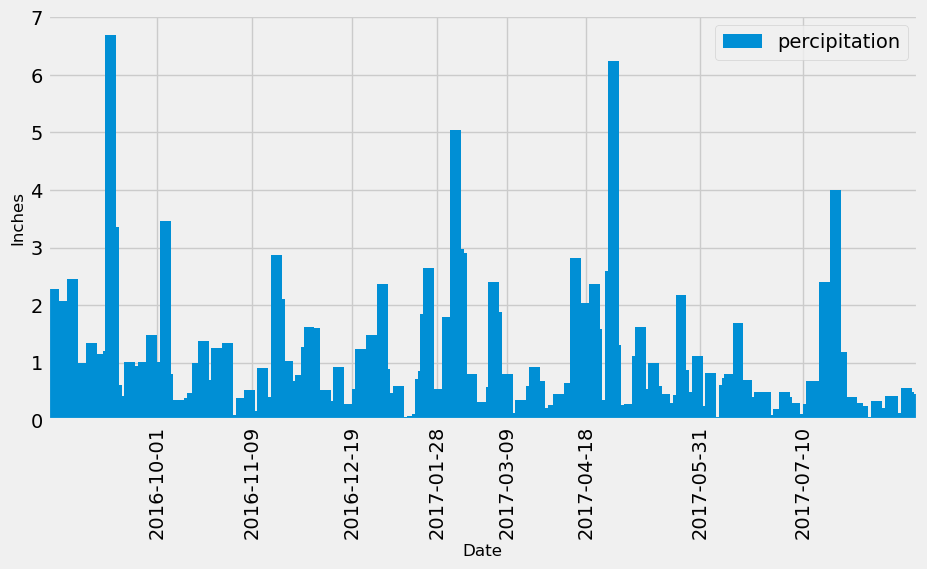

In [39]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
recent_date = dt.datetime.strptime(recent_date, '%Y-%m-%d').date()

# Calculate the date one year from the last date in data set.
filter_date = dt.datetime(recent_date.year -1, recent_date.month, recent_date.day)

# Perform a query to retrieve the data and precipitation scores
sql = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= filter_date)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.read_sql(sql = sql.statement, con = engine)

# Sort the dataframe by date
measurement_df = df.groupby(['date']).max(['prcp'])

measurement_df = measurement_df[measurement_df.prcp > 0.0].sort_values(['date']).reset_index()
measurement_df = measurement_df.rename(columns={'prcp': 'percipitation'})

# Use Pandas Plotting with Matplotlib to plot the data
ticks_labels = ['2016-08-23','2016-10-01','2016-11-09','2016-12-19','2017-01-28','2017-03-09','2017-04-18','2017-05-31','2017-07-10']
ticks = measurement_df.index[measurement_df['date'].isin(ticks_labels)].tolist()

ax = measurement_df.plot.bar(x='date', y='percipitation', rot=90, legend=False, figsize=(10,5), width=4)
ax.set(xticks=(ticks))
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Inches', fontsize=12)
ax.legend()


In [40]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [29]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station).count()
print(station_count)

9


In [30]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
#Station.__table__.columns.keys()
most_active_stations_query = session.query(Measurement.station, func.count(Measurement.station).label('count')).group_by(Measurement.station)
print(most_active_stations_query)
most_active_stations_df = pd.read_sql(sql = most_active_stations_query.statement, con = engine).dropna().sort_values('count', ascending=False)
most_active_stations_df

SELECT measurement.station AS measurement_station, count(measurement.station) AS count 
FROM measurement GROUP BY measurement.station


,station,count
6,USC00519281,2772
7,USC00519397,2724
1,USC00513117,2709
8,USC00519523,2669
3,USC00516128,2612
2,USC00514830,2202
0,USC00511918,1979
4,USC00517948,1372
5,USC00518838,511


In [31]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station =  most_active_stations_df.iloc[0]['station']
most_active_station

session.query(
                Measurement.station, 
                func.min(Measurement.prcp), 
                func.max(Measurement.prcp),
                func.avg(Measurement.prcp)
             ).group_by(Measurement.station).filter(Measurement.station == most_active_station).all()


[('USC00519281', 0.0, 9.64, 0.2123520923520915)]

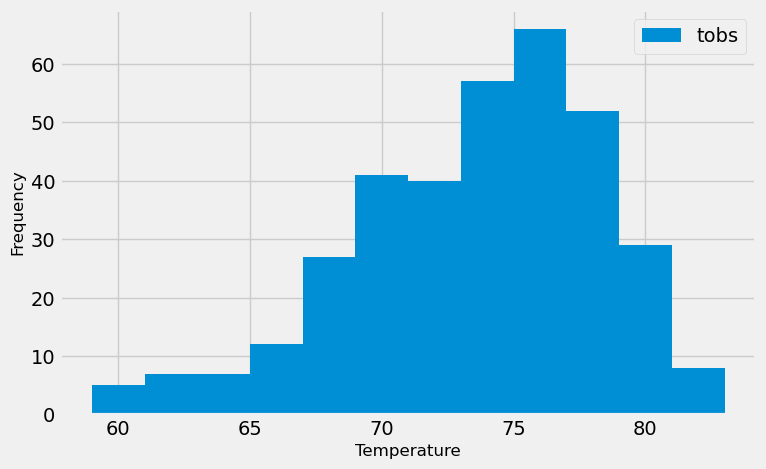

In [32]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_tobs_query = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= filter_date, Measurement.station == most_active_station)
most_active_station_tobs_df = pd.read_sql(sql = most_active_station_tobs_query.statement, con = engine)

ax = most_active_station_tobs_df.hist(column='tobs', bins=12, legend=True, figsize=(8,5))

for x in ax.flatten():
    x.set_xlabel('Temperature', fontsize=12)
    x.set_ylabel('Frequency', fontsize=12)
    x.set_title('')


# Close Session

In [33]:
# Close Session
session.close()